### CMAP

**NOT UP TO DATE**

This notebook prepares a dataset with 24 individual knockout experiments applied to CD4 T cells ([Freimer et al 2020](https://www.nature.com/articles/s41588-022-01106-y)). Each knockout was profiled with both ATAC and RNA-seq measurements, but we use only RNA. The data have UMI's. Controls are 8 guide RNA's targeting the "safe-harbor" AAVS1 locus, and are labeled `AAVS1_1`, `AAVS1_8`, etc. The experiment was done separately on blood from 3 different donors.

Here we tidy the dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is still useful for data exploration.)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbations/")

### Reshape the data

In [2]:
expression_quantified = ad.concat([
    ingestion.read_cmap( 
        expression_file = 'not_ready/cmap/level3_beta_ctl_n188708x12328.gctx',
        gene_metadata = "not_ready/cmap/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz",
        instance_metadata = "not_ready/cmap/instinfo_beta.txt", 
    ),
    ingestion.read_cmap( 
        expression_file = 'not_ready/cmap/level3_beta_trt_oe_n131668x12328.gctx',
        gene_metadata = "not_ready/cmap/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz",
        instance_metadata = "not_ready/cmap/instinfo_beta.txt", 
    ),
])
expression_quantified
expression_quantified.raw = expression_quantified.copy()

: 

: 

In [ ]:
# concat discards gene metadata even with "outer". grrr. have to remake it.
expression_quantified.var = pd.merge(
    expression_quantified.var, 
    pd.read_csv("not_ready/cmap/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz", sep = "\t"),
    how = "left", 
    left_index = True,
    right_on = "pr_gene_symbol",
)
expression_quantified.var_names = expression_quantified.var["pr_gene_symbol"]

pr_gene_id pr_gene_symbol  \
pr_gene_symbol                              
NAT2                    10           NAT2   
ADA                    100            ADA   
CDH2                  1000           CDH2   
AKT3                 10000           AKT3   
MED6                 10001           MED6   
...                    ...            ...   
SLC12A6               9990        SLC12A6   
PTBP3                 9991          PTBP3   
KCNE2                 9992          KCNE2   
DGCR2                 9993          DGCR2   
SCO2                  9997           SCO2   

                                                    pr_gene_title  pr_is_lm  \
pr_gene_symbol                                                                
NAT2            N-acetyltransferase 2 (arylamine N-acetyltrans...         0   
ADA                                           adenosine deaminase         0   
CDH2                                                   cadherin 2         0   
AKT3                v-akt murine thymoma viral oncogene homolog 3         0   
MED6                                   mediator complex subunit 6         0   
...                                                           ...       ...   
SLC12A6         solute carrier family 12 (potassium/chloride t...         0   
PTBP3                      polypyrimidine tract binding protein 3         0   
KCNE2           potassium channel, voltage gated subfamily E r...         0   
DGCR2                    DiGeorge syndrome critical region gene 2         0   
SCO2                   SCO2 cytochrome c oxidase assembly protein         0   

                pr_is_bing  
pr_gene_symbol              
NAT2                     0  
ADA                      1  
CDH2                     1  
AKT3                     1  
MED6                     1  
...                    ...  
SLC12A6                  1  
PTBP3                    1  
KCNE2                    0  
DGCR2                    1  
SCO2                     1  

[12328 rows x 5 columns]

In [4]:
# Find names of genes perturbed
perturbation_metadata = pd.read_csv("not_ready/cmap/GSE92742_Broad_LINCS_pert_info.txt.gz", sep = "\t")
print(perturbation_metadata.head())
expression_quantified.obs = pd.merge(
    expression_quantified.obs,
    perturbation_metadata,
    left_on = "pert_id", ???
    right_on = "pert_id",
)
expression_quantified.obs["perturbation"] = expression_quantified.obs["pert_iname"] 

      pert_id pert_iname   pert_type  is_touchstone inchi_key_prefix  \
0       56582       AKT2      trt_oe              0             -666   
1        5981       HSF1      trt_oe              0             -666   
2        7150     NFE2L2      trt_oe              0             -666   
3    ABL1_G2A       ABL1  trt_oe.mut              0             -666   
4  ABL1_T315I       ABL1  trt_oe.mut              0             -666   

  inchi_key canonical_smiles pubchem_cid  
0      -666             -666        -666  
1      -666             -666        -666  
2      -666             -666        -666  
3      -666             -666        -666  
4      -666             -666        -666  


NameError: name 'expression_quantified' is not defined

: 

### Count up different perturbations

In [6]:
human_TFs = pd.read_csv("../accessory_data/humanTFs.csv")
human_TFs = human_TFs.loc[human_TFs["Is TF?"]=="Yes",:]

perturbation_metadata = pd.read_csv("not_ready/cmap/GSE92742_Broad_LINCS_pert_info.txt.gz", sep = "\t")
print("\n\nperturbation metadata")
display(perturbation_metadata)
meta_with_pert_meta = pd.merge(
    expression_quantified.obs,
    perturbation_metadata, 
    on = "pert_id",
    how = "left",
)
meta_with_pert_meta["is_tf"] = meta_with_pert_meta["pert_iname"].isin(human_TFs["HGNC symbol"])
print("\n\nperturbation frequencies")
print(meta_with_pert_meta["pert_iname"].value_counts())
print("\n\nperturbation frequencies (just TF's)")
print(meta_with_pert_meta.query("is_tf")["pert_iname"].value_counts())

perturbation_metadata


pert_id  pert_iname   pert_type  is_touchstone  \
0                   56582        AKT2      trt_oe              0   
1                    5981        HSF1      trt_oe              0   
2                    7150      NFE2L2      trt_oe              0   
3                ABL1_G2A        ABL1  trt_oe.mut              0   
4              ABL1_T315I        ABL1  trt_oe.mut              0   
...                   ...         ...         ...            ...   
51378  ccsbBroad304_99991  LUCIFERASE  ctl_vector              0   
51379  ccsbBroad304_99994        lacZ  ctl_vector              0   
51380  ccsbBroad304_99997        eGFP  ctl_vector              0   
51381               dsRED       DSRED      trt_oe              0   
51382             renilla     RENILLA      trt_oe              0   

      inchi_key_prefix inchi_key canonical_smiles pubchem_cid  
0                 -666      -666             -666        -666  
1                 -666      -666             -666        -666  
2                 -666      -666             -666        -666  
3                 -666      -666             -666        -666  
4                 -666      -666             -666        -666  
...                ...       ...              ...         ...  
51378             -666      -666             -666        -666  
51379             -666      -666             -666        -666  
51380             -666      -666             -666        -666  
51381             -666      -666             -666        -666  
51382             -666      -666             -666        -666  

[51383 rows x 8 columns]

perturbation frequencies
DMSO            101323
UnTrt            30095
GFP               6831
pgw               5505
EMPTY_VECTOR      5449
                 ...  
YY1                  1
PLK2                 1
TRAF5                1
PRKCQ                1
DCAMKL2              1
Name: pert_iname, Length: 1217, dtype: int64
perturbation frequencies (just TF's)
ALK       134
NFE2L2    127
HSF1      124
MET       104
ABL1       89
         ... 
TRAF5       1
YY1         1
BCL6        1
RFX3        1
TRIM26      1
Name: pert_iname, Length: 708, dtype: int64


### Add `is_control` and `perturbation`

In [7]:
print(expression_quantified.obs.columns)
print(expression_quantified.obs["pert_type"].value_counts())
controls = ["ctl_vector"]
expression_quantified.obs['perturbation'] = expression_quantified.obs["pert_id"]
expression_quantified.obs["is_control"] = expression_quantified.obs['pert_type'].isin(controls).astype(int)

Index(['sample_id', 'bead_batch', 'nearest_dose', 'pert_dose',
       'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime',
       'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate',
       'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv',
       'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname',
       'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode',
       'project_code', 'cmap_name'],
      dtype='object')
trt_oe         131668
ctl_vehicle    102696
ctl_vector      55905
ctl_untrt       30095
ctl_x              12
Name: pert_type, dtype: int64


### Basic unsupervised analysis

In [8]:
expression_quantified.X
# This is just to estimate the mean and dispersion, but we'll use all 978 landmark genes.
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)

In [9]:
expression_quantified.var["highly_variable"] = expression_quantified.var["pr_is_lm"]==1
expression_quantified.var

pr_gene_id pr_gene_symbol  \
pr_gene_symbol                              
NAT2                    10           NAT2   
ADA                    100            ADA   
CDH2                  1000           CDH2   
AKT3                 10000           AKT3   
MED6                 10001           MED6   
...                    ...            ...   
SLC12A6               9990        SLC12A6   
PTBP3                 9991          PTBP3   
KCNE2                 9992          KCNE2   
DGCR2                 9993          DGCR2   
SCO2                  9997           SCO2   

                                                    pr_gene_title  pr_is_lm  \
pr_gene_symbol                                                                
NAT2            N-acetyltransferase 2 (arylamine N-acetyltrans...         0   
ADA                                           adenosine deaminase         0   
CDH2                                                   cadherin 2         0   
AKT3                v-akt murine thymoma viral oncogene homolog 3         0   
MED6                                   mediator complex subunit 6         0   
...                                                           ...       ...   
SLC12A6         solute carrier family 12 (potassium/chloride t...         0   
PTBP3                      polypyrimidine tract binding protein 3         0   
KCNE2           potassium channel, voltage gated subfamily E r...         0   
DGCR2                    DiGeorge syndrome critical region gene 2         0   
SCO2                   SCO2 cytochrome c oxidase assembly protein         0   

                pr_is_bing  highly_variable      means  dispersions  \
pr_gene_symbol                                                        
NAT2                     0            False  11.551076    14.638283   
ADA                      1            False   9.178210    13.041871   
CDH2                     1            False   7.625913    11.729268   
AKT3                     1            False   8.268739    12.629054   
MED6                     1            False   8.252317     9.329808   
...                    ...              ...        ...          ...   
SLC12A6                  1            False   6.614356     6.907102   
PTBP3                    1            False   7.052709    10.563398   
KCNE2                    0            False   7.365913     7.409789   
DGCR2                    1            False   8.183574    10.137766   
SCO2                     1            False   8.545659     9.437621   

                dispersions_norm  
pr_gene_symbol                    
NAT2                    1.938345  
ADA                     1.361508  
CDH2                    1.192294  
AKT3                    1.443965  
MED6                   -0.949202  
...                          ...  
SLC12A6                -1.071002  
PTBP3                   0.629410  
KCNE2                  -1.369137  
DGCR2                  -0.209147  
SCO2                   -1.021808  

[12328 rows x 9 columns]

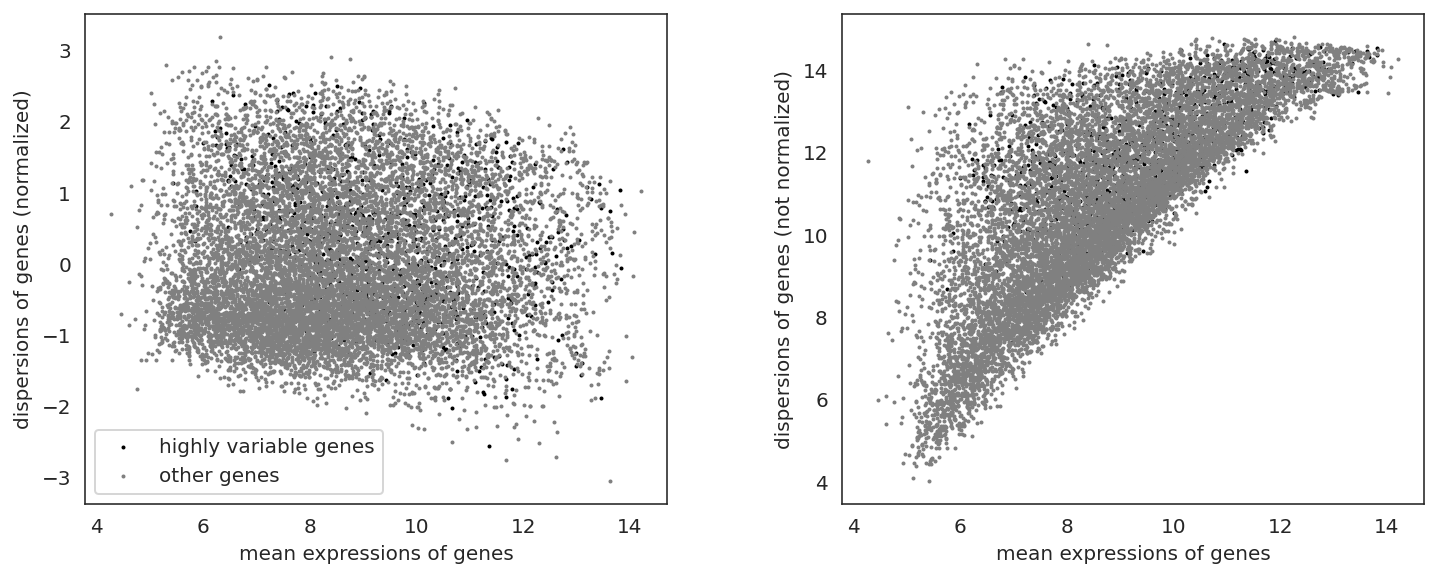

In [10]:
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)

In [ ]:
expression_quantified.obs = ingestion.simplify_categorical(expression_quantified.obs, column = "cell_iname")

In [13]:
expression_quantified.obs["cell_iname_simplified"].value_counts()

other      39065
A549       35677
PC3        34993
A375       30924
MCF7       30201
HA1E       26844
HT29       23044
VCAP       19603
HEK293T    15137
HEPG2      13863
HCC515     13695
U2OS        6946
YAPC        4871
AALE        4087
HELA        3585
NPC         3509
MCF10A      3440
H1299       3350
SALE        2894
ES2         2357
THP1        2291
Name: cell_iname_simplified, dtype: int64

Index(['sample_id', 'bead_batch', 'nearest_dose', 'pert_dose',
       'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime',
       'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate',
       'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv',
       'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type',
       'cell_iname_x', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name',
       'failure_mode', 'project_code', 'cmap_name', 'perturbation',
       'is_control', 'leiden', 'cell_iname_y', 'cell_iname_simplified'],
      dtype='object')


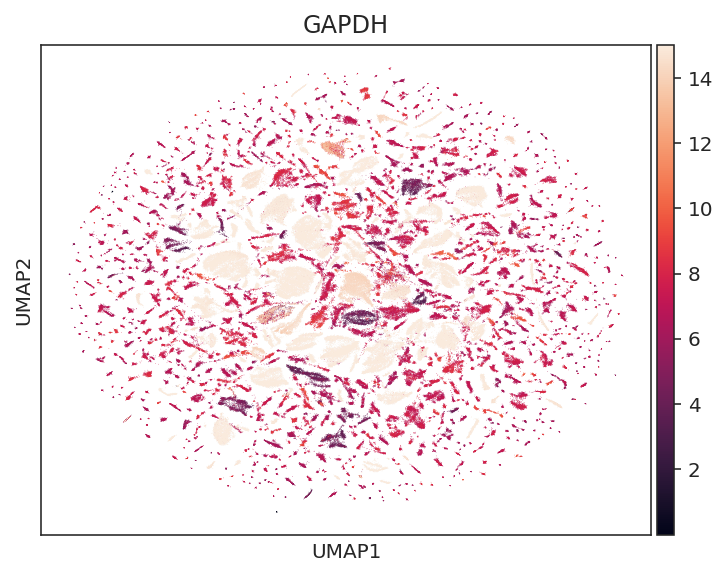

None


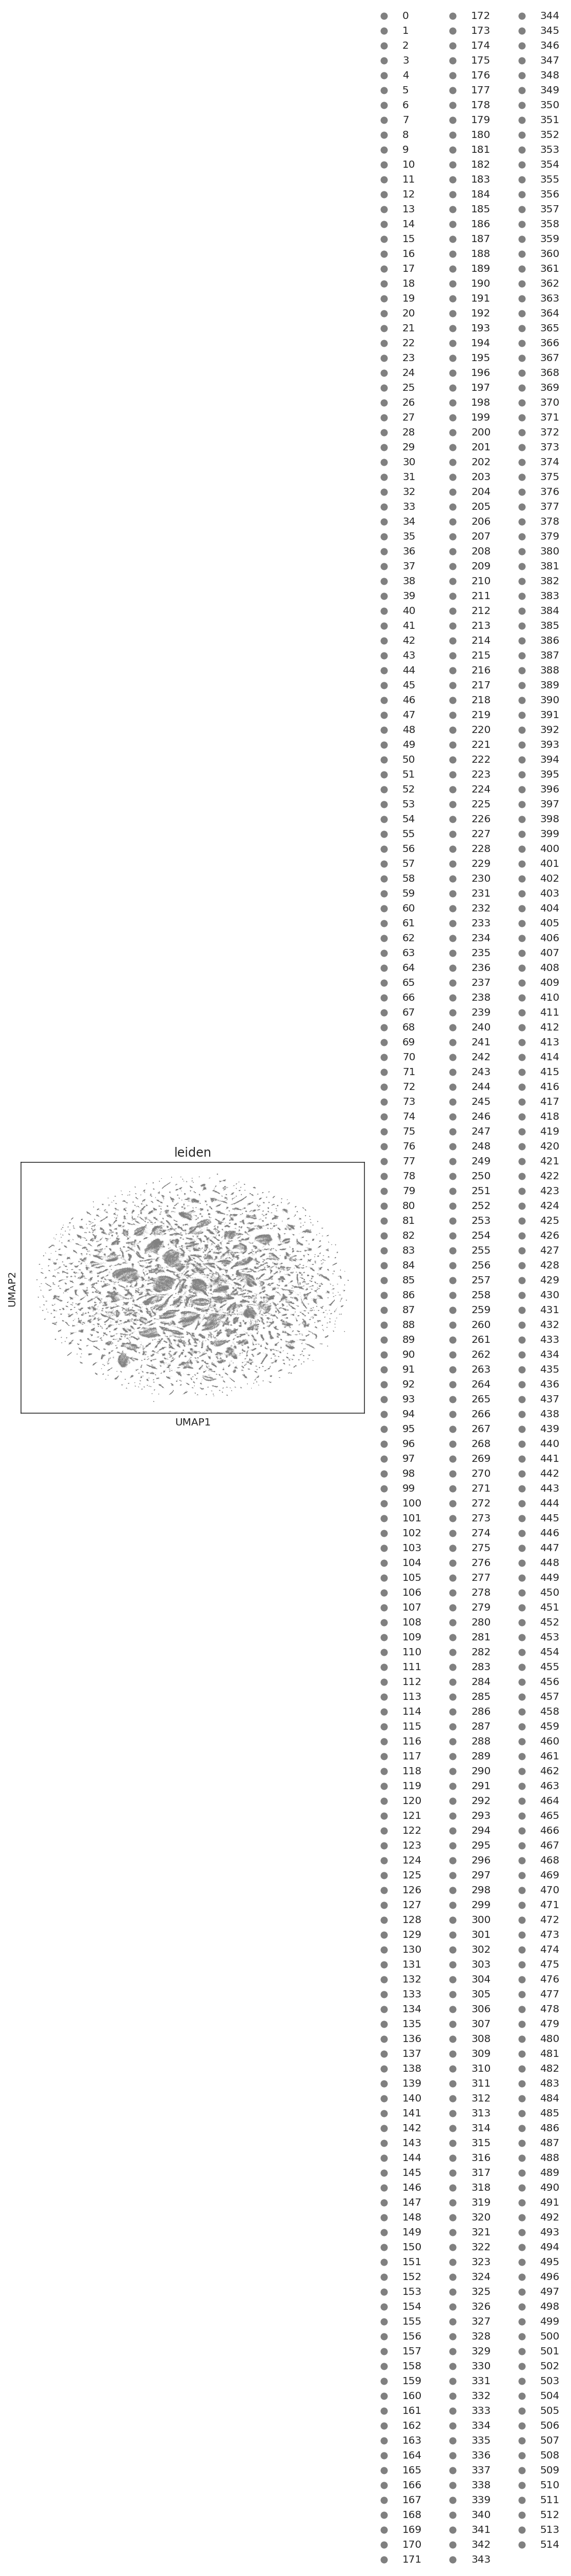

None


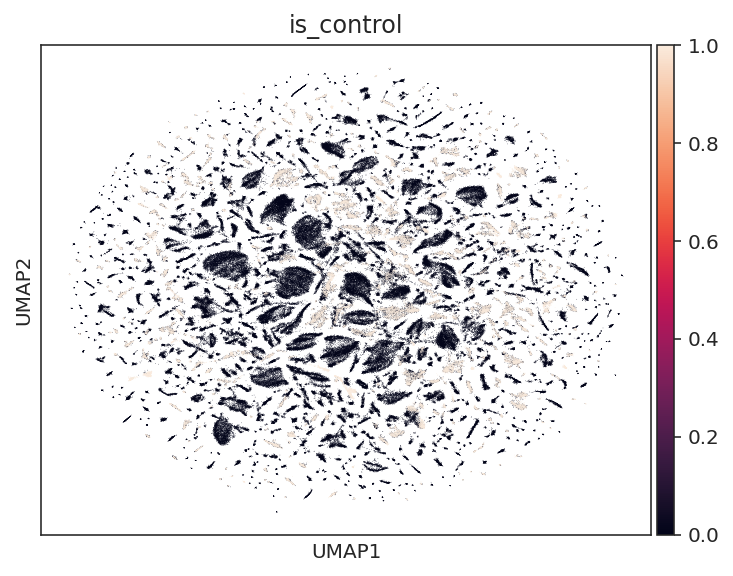

None


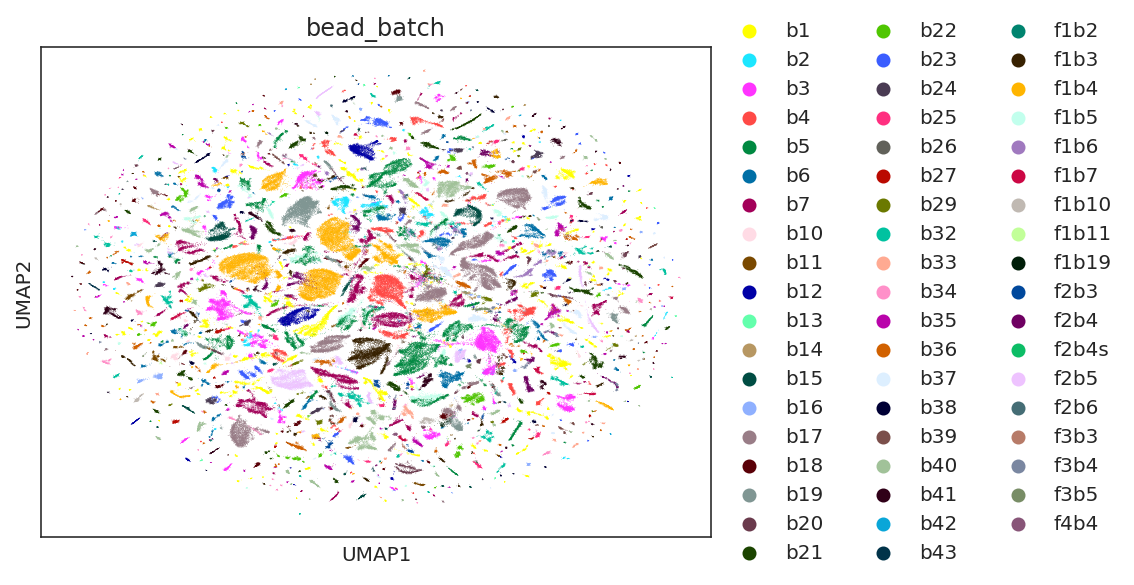

None


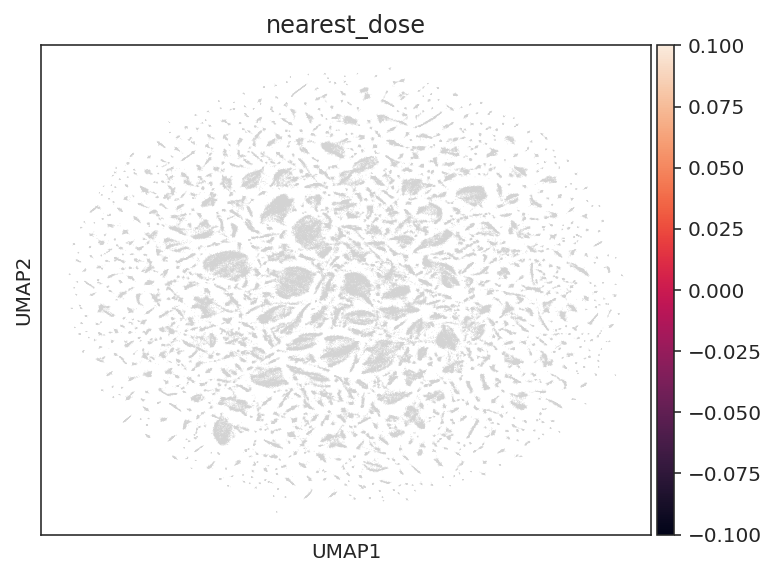

None


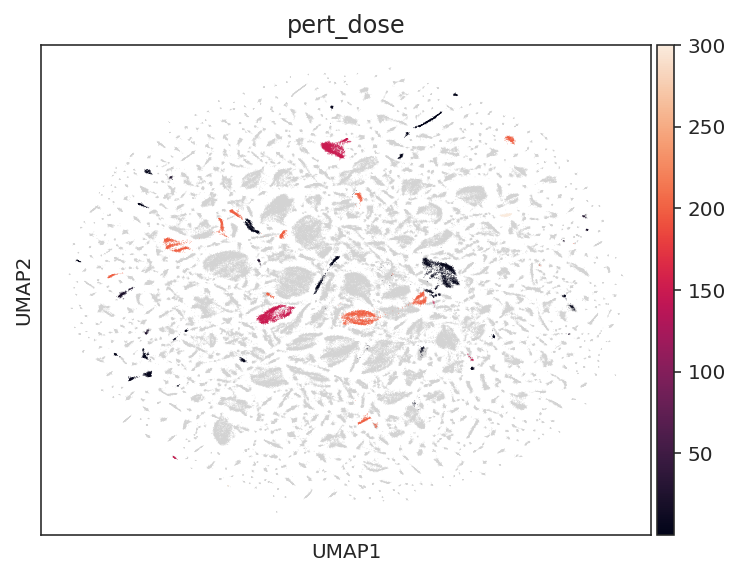

None


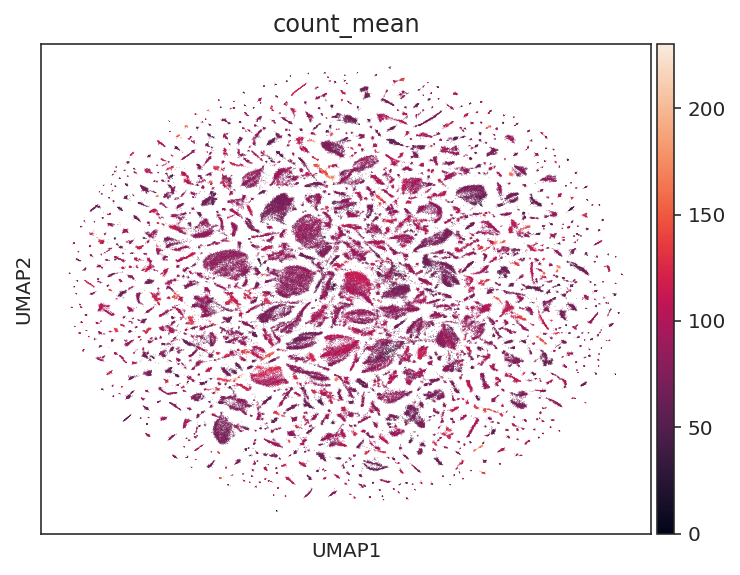

None


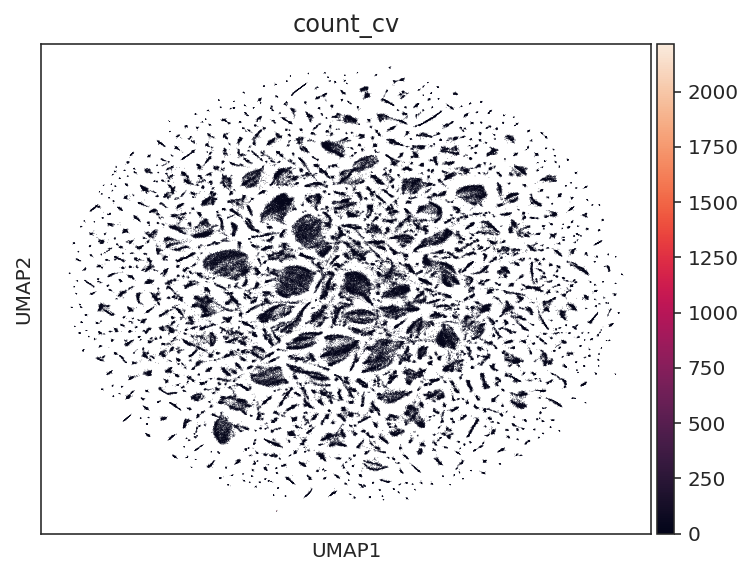

None


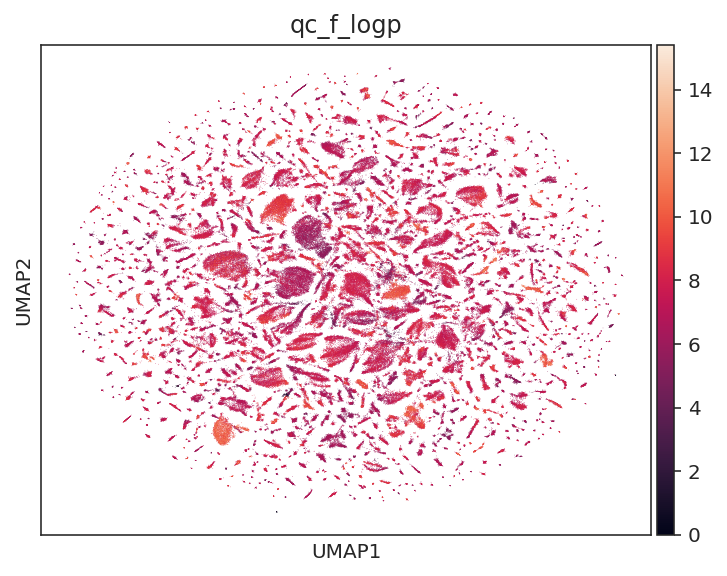

None


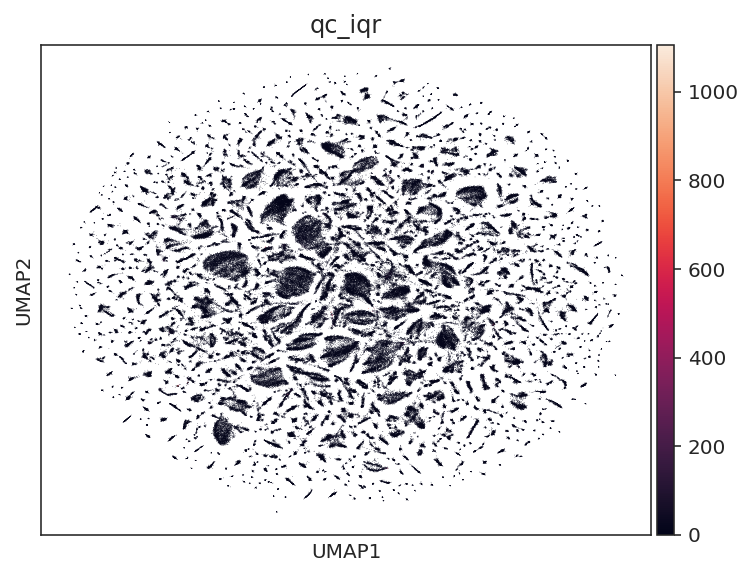

None


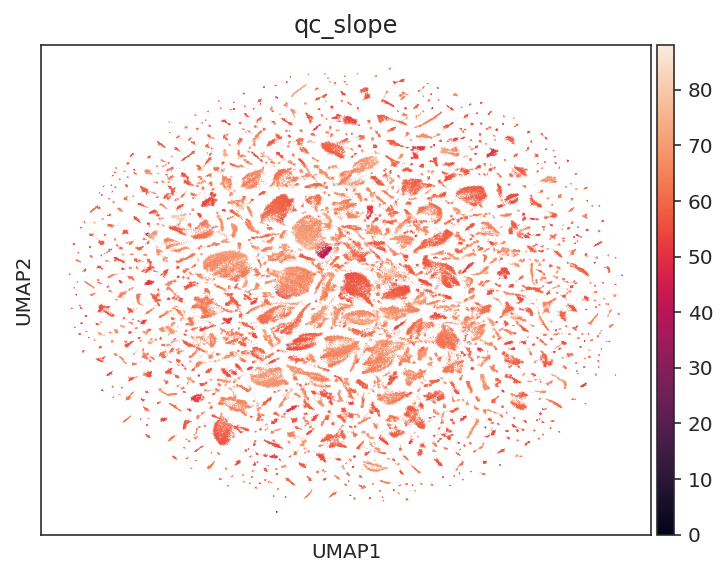

None


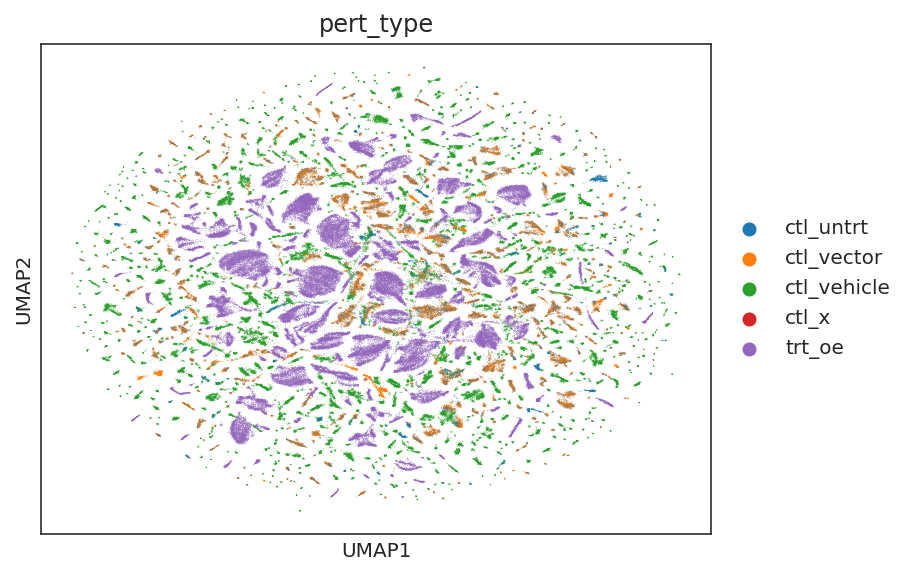

None


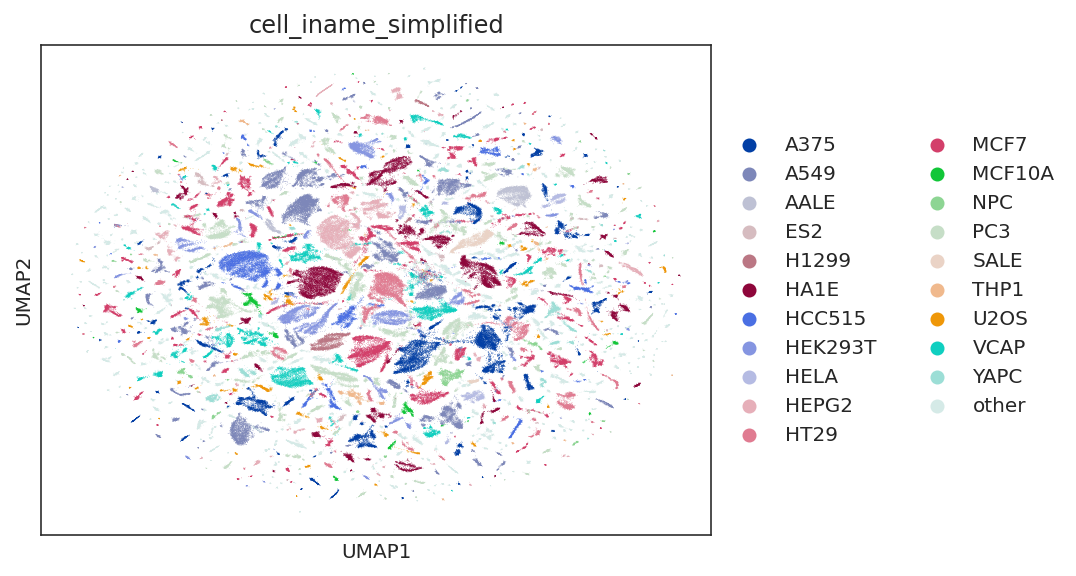

None


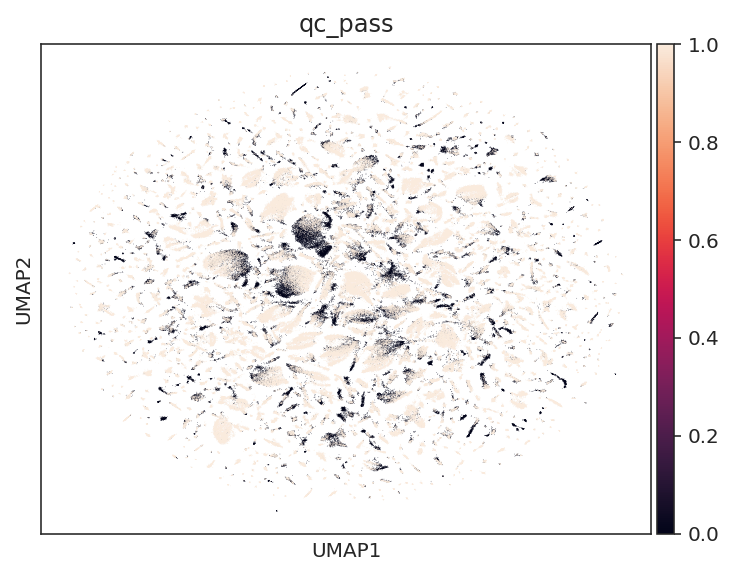

None


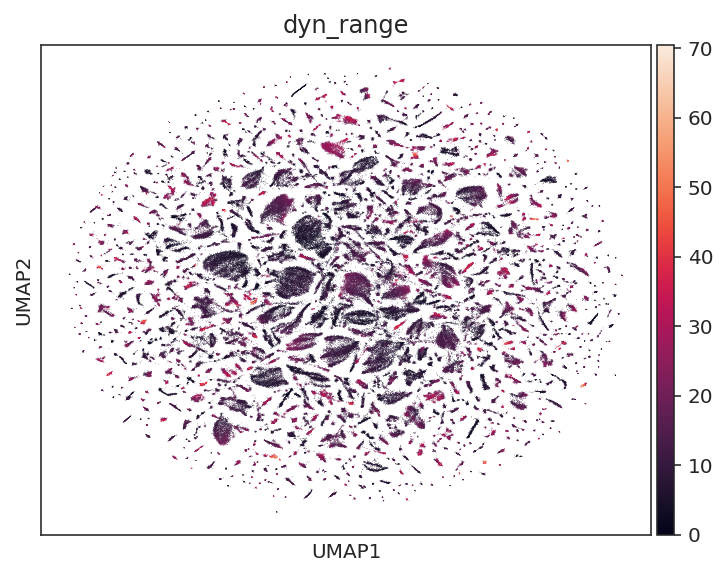

None


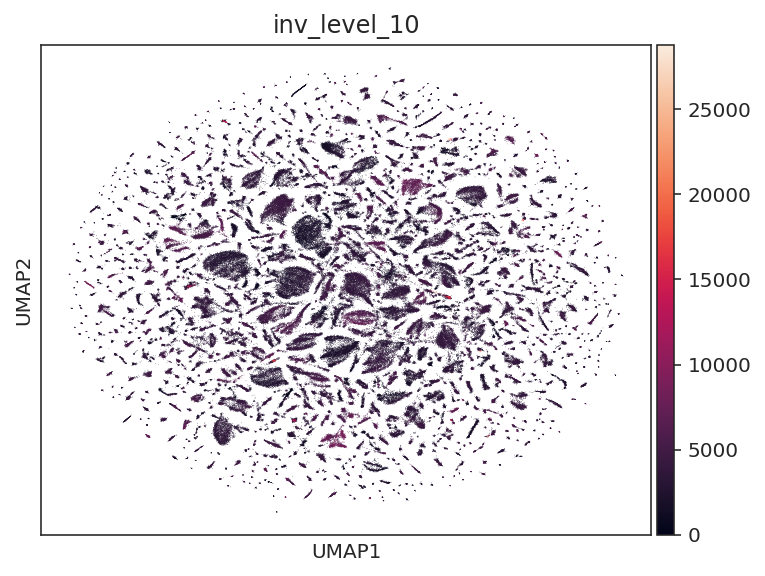

None


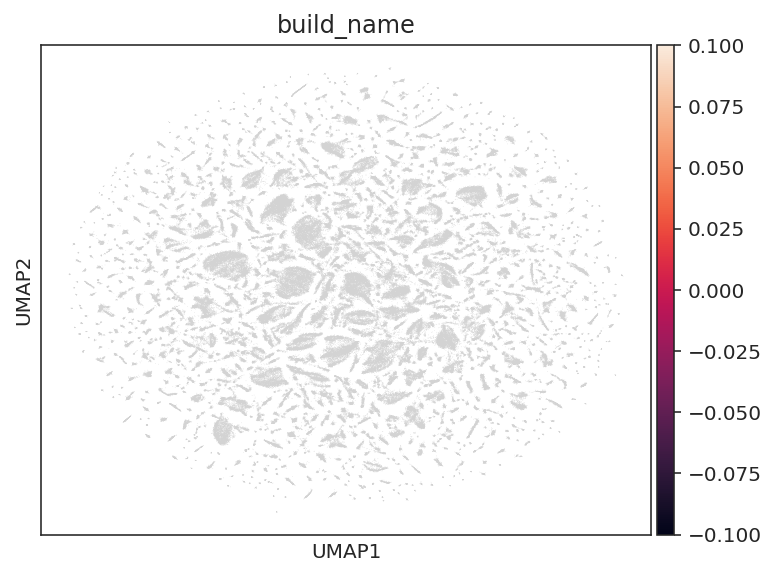

None


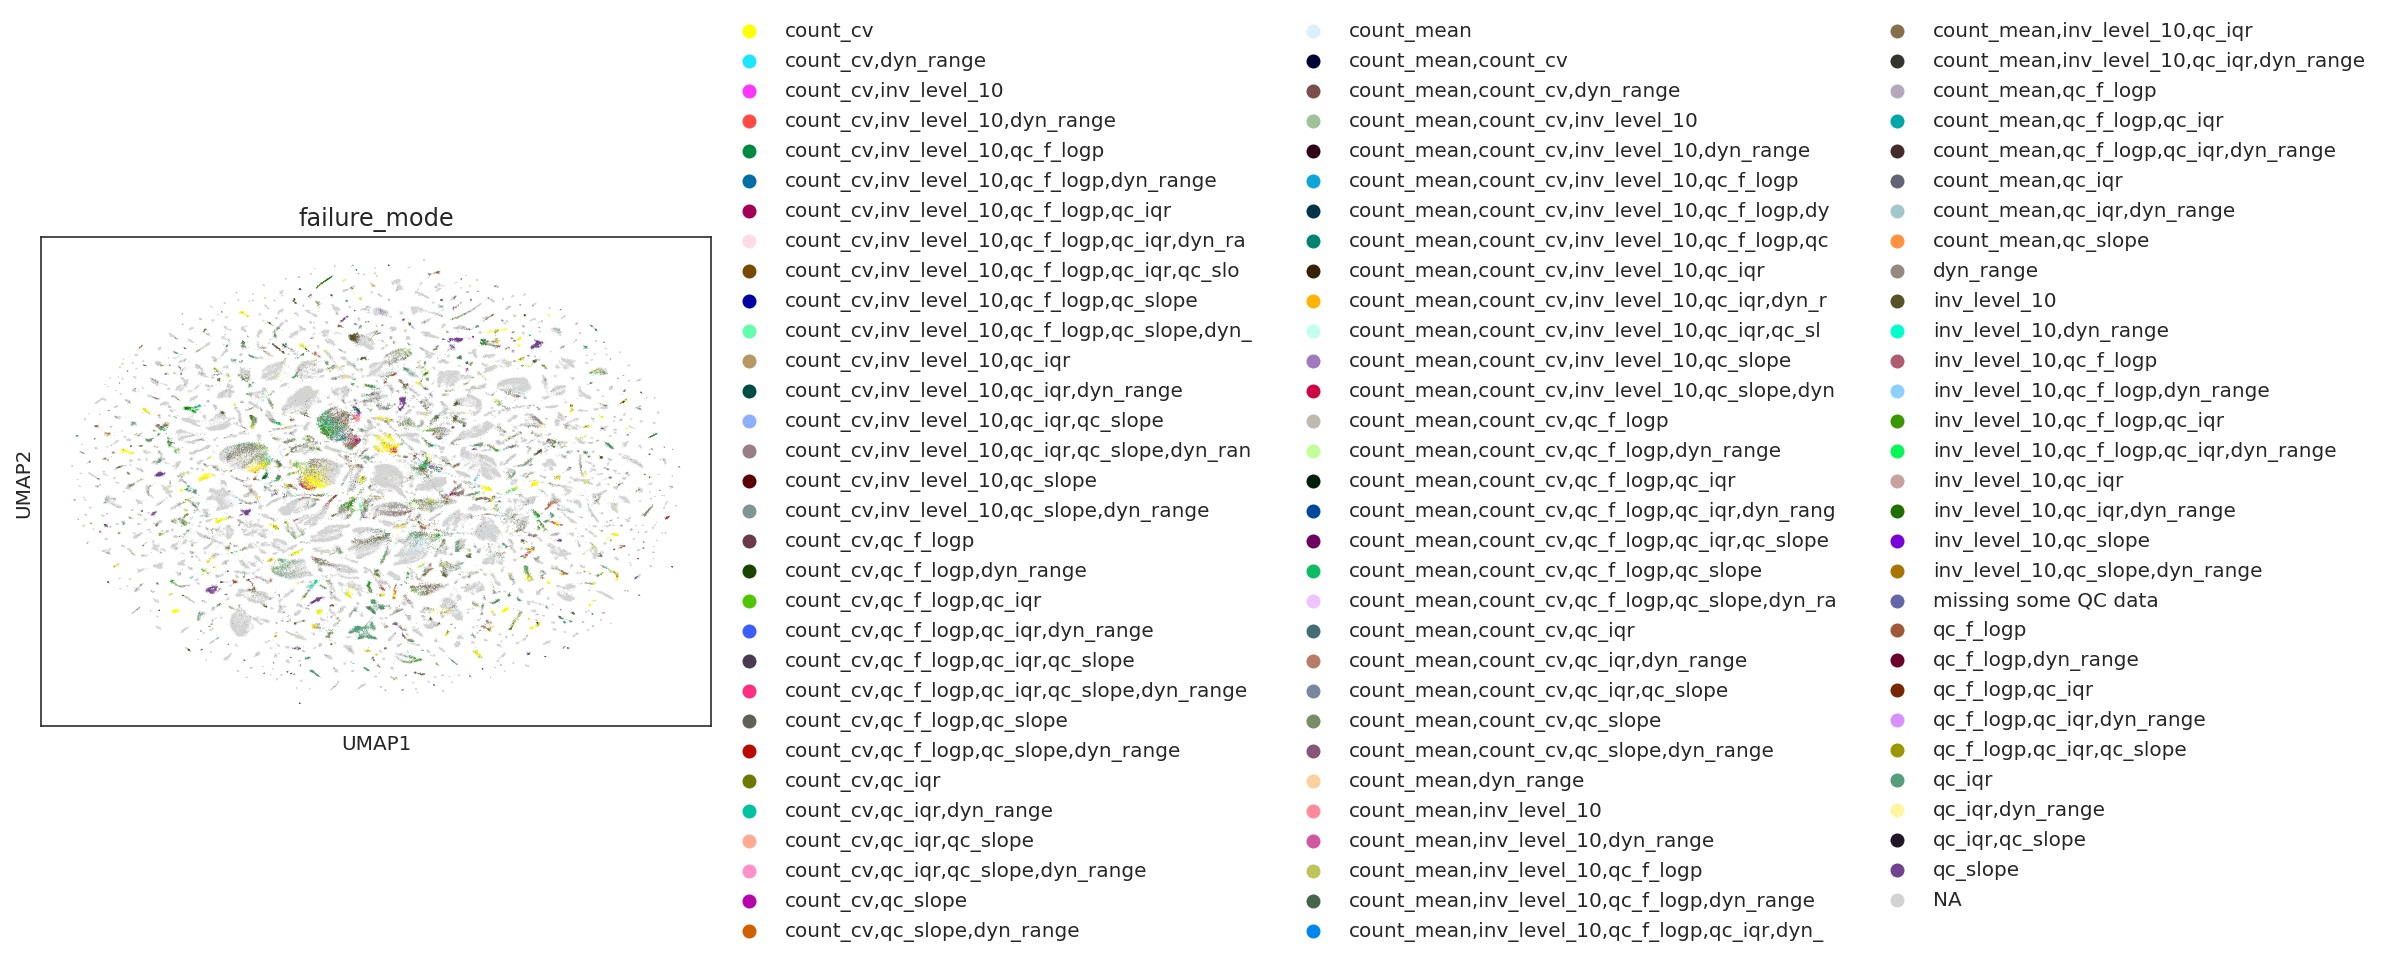

None


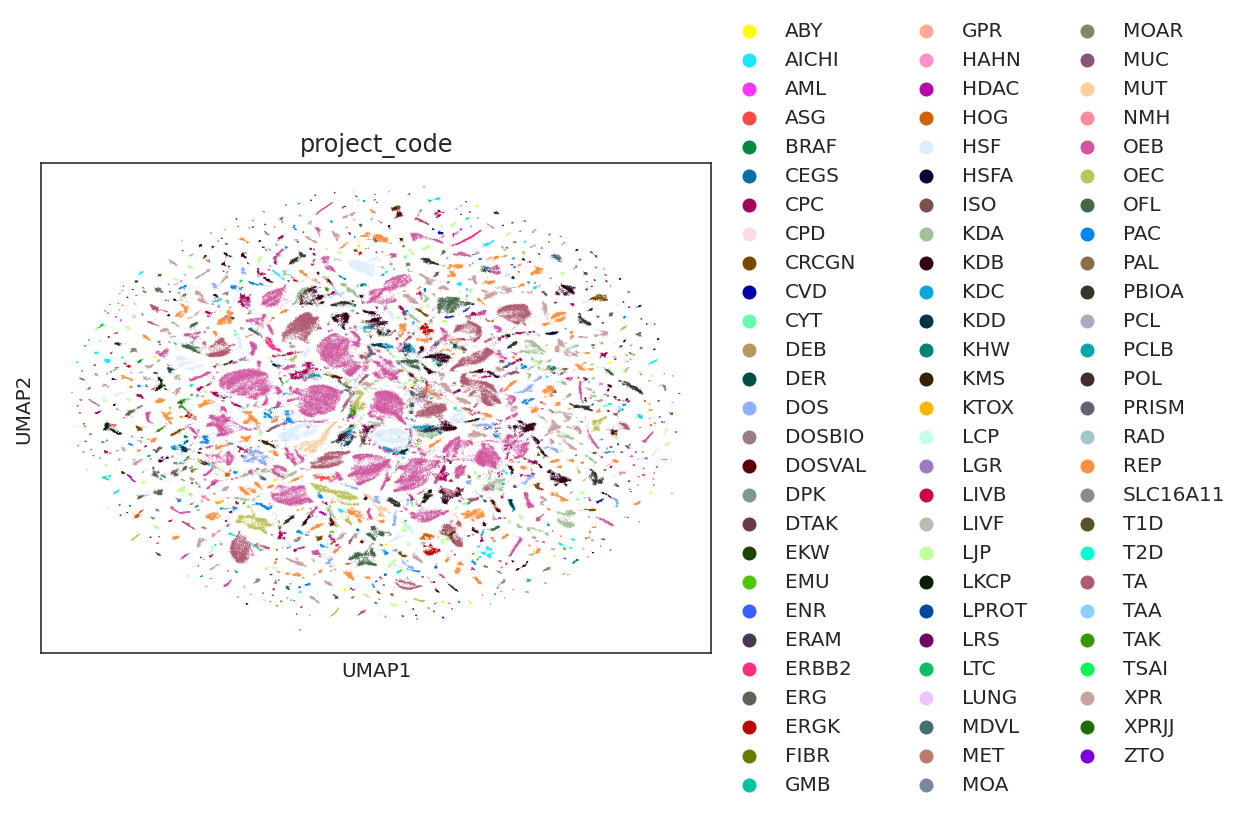

None


In [11]:
print(expression_quantified.obs.columns)
for l in [
    "GAPDH", "leiden", "is_control",
     'bead_batch', 'nearest_dose', 'pert_dose',
    'count_mean', 'count_cv',
    'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_type', 'cell_iname_simplified',
    'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode',
    'project_code',
    ]:
    try:
        print(sc.pl.umap(expression_quantified, color = l))
    except Exception as e:
        print("Error on input\n" + l + ":\n" + repr(e))
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [14]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified.copy()
print("These genes were perturbed and measured:")
print(perturbed_and_measured_genes)
print("These genes were perturbed but not measured:")
print(sorted(list(perturbed_but_not_measured_genes)))
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))
print("Actually, nevermind. Let us keep just the 978 landmark genes.")
genes_keep = expression_quantified.var.index[expression_quantified.var['pr_is_lm']]
expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "overexpression")


These genes were perturbed and measured:
{'NFE2L2', 'FOSL1', 'TEK', 'RELB', 'HSF1', 'DENND2D', 'MAP2K1', 'JAK2', 'CDCA4', 'INSR', 'MTOR', 'PSME1', 'JAK1'}
These genes were perturbed but not measured:
['10102_R333W', '10102_WT', '1026_D149G', '1026_R67L', '1026_R84Q', '1026_S31R', '1026_WT', '1045_WT', '10475', '114327_P77T', '114327_R221H', '114327_T508R', '114327_WT', '1414_S228P', '1414_WT', '1420_R168W', '1420_T5P', '1420_WT', '1678_C66W', '1678_WT', '1991_A32V', '1991_C122S', '1991_G181V', '1991_WT', '2010_D72V', '2010_P183T', '2010_S54F', '2010_WT', '2099_R548C', '2099_WT', '2120|5159_WT', '2263_N549H', '2263_WT', '2524', '2908_D401H', '2908_D641V', '2908_I747M', '2908_R23K', '2908_WT', '3172_C93W', '3172_E285D', '3172_R324H', '3172_V264M', '3172_WT', '3205_WT', '3337_WT', '3337|5566_WT', '3456_WT', '3982_F147V', '3982_G196E', '3982_WT', '4000_PROGERIN', '4000_WT', '4693_C128R', '4693_I18K', '4693_S101F', '4693_WT', '4693_Y44C', '4758_G136E', '4758_L231H', '4758_L91R', '4758_R341G

In [15]:
# final form, ready to save
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

In [16]:
os.makedirs("perturbations/cmap", exist_ok = True)
expression_quantified.write_h5ad("perturbations/cmap/test.h5ad")